# Incremental Collaborative Filtering (ICR) - Algorithm experiments

Movielens 100k data set: https://maxhalford.github.io/files/datasets/ml_100k.zip

In [1]:
import csv
import matplotlib.pyplot as plt

In [2]:
def stream(filepath, delimiter, max_cases=500):
    with open(filepath, 'r') as csvf:
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf, delimiter=delimiter)
        n=0
        for row in csvReader:
            if n == max_cases:
                break
            n+=1
            yield row['user'], row['item'], float(row['rating'])

In [3]:
class myICF():
    def __init__(self):
        self.user_ratings = {} # Dict to store ratings
        self.user_meta = {} # Dict to cache users info on number of ratings and average ratings
        self.user_pair_meta = {} # Dict to cache info on factors calculated for pairs of users (B, C, D, sum of ratings to co-rated items)
        self.corr_threshold=0.65
        self.high_rating=4
   
    def _new_user(self, user, item, rating):
        # initialize new user
        self.user_ratings[user] = {} # initializes user in ratings dict
        self.user_meta[user] = {'q': 0, 'avg.rating': 0} # initializes user in meta dict, assign number of items user has rated and avg rating of user

        # initializes pairs of existing users with new user in user_pair_meta dict
        for u in self.user_meta.keys(): 
            if u == user:
                continue
            self.user_pair_meta[(u, user)] = {'B': 0, 'C': 0, 'D': 0}
            self.user_pair_meta[(u, user)]['sum.co_ratings'] = {u: 0, user: 0, 'n': 0}
            
    def _new_rating(self, user, item, rating):
        # Submission of a new rating
        q = self.user_meta[user]['q'] # gets number of items user has rated
        A_avg_rating = self.user_meta[user]['avg.rating']
        new_avg = ( rating/( q+1 ) ) + ( q/( q+1 ) )*A_avg_rating # calculates new avg rating for active user
        delta_avg = new_avg - A_avg_rating # difference of user's previous and current avg rating
        
        for userB in self.user_meta.keys():
            if userB == user:
                continue
                        
            B_avg_rating = self.user_meta[userB]['avg.rating']
            
            if item in self.user_ratings[userB].keys():
                # User B has rated the item                
                A_sum_coratings, B_sum_coratings, n_coratings, key = self._update_get_coratings(user, userB, item, rating, new_rating=True)
                B_rating = self.user_ratings[userB][item]
                
                e = ( rating-new_avg )*( B_rating-B_avg_rating ) - delta_avg*( B_sum_coratings - n_coratings*B_avg_rating )
                f = ( rating-new_avg )**2 + n_coratings*(delta_avg**2) - 2*delta_avg*( A_sum_coratings - n_coratings*A_avg_rating )
                g = ( B_rating-B_avg_rating )**2
                
            else:
                # User B had not rated the item
                A_sum_coratings, B_sum_coratings, n_coratings, key = self._get_coratings(user, userB)
                
                e = - delta_avg*( B_sum_coratings - n_coratings*B_avg_rating )
                f = n_coratings*(delta_avg**2) - 2*delta_avg*( A_sum_coratings - n_coratings*A_avg_rating )
                g = 0
            
            for factor, increment in zip(['B', 'C', 'D'], [e, f, g]):
                self.user_pair_meta[key][factor] += increment
        
        self.user_ratings[user][item] = rating # updates rating given by user to item
        self.user_meta[user]['q'] += 1 # updates number of items user has rated
        self.user_meta[user]['avg.rating'] = new_avg # updates avg rating
        
        
    def _update_rating(self, user, item, rating):
        # Update of an existing rating
        delta_rating = rating - self.user_ratings[user][item] # difference of user's previous and current rating for item
        q = self.user_meta[user]['q'] # gets number of items user has rated
        A_avg_rating = self.user_meta[user]['avg.rating']
        new_avg = delta_rating/q + A_avg_rating # calculates new avg rating for active user
        delta_avg = new_avg - A_avg_rating # difference of user's previous and current avg rating
        
        for userB in self.user_meta.keys():
            if userB == user:
                continue
                            
            B_avg_rating = self.user_meta[userB]['avg.rating']
            
            if item in self.user_ratings[userB].keys():
                # User B has rated the item                
                A_sum_coratings, B_sum_coratings, n_coratings, key = self._update_get_coratings(user, userB, item, rating, new_rating=False)
                B_rating = self.user_ratings[userB][item]
                
                e = delta_rating*( B_rating-B_avg_rating ) - delta_avg*( B_sum_coratings - n_coratings*B_avg_rating )
                # computation of f is not clear for both cases
                f = delta_rating**2 + 2*delta_rating*( rating-new_avg ) + n_coratings*delta_avg**2 - 2*delta_avg*( A_sum_coratings - n_coratings*A_avg_rating )
                g = 0
            else:
                # User B had not rated the item
                A_sum_coratings, B_sum_coratings, n_coratings, key = self._get_coratings(user, userB)
                
                e = - delta_avg*( B_sum_coratings - n_coratings*B_avg_rating )
                # computation of f is not clear for both cases
                f = n_coratings*delta_avg**2 - 2*delta_avg*( A_sum_coratings - n_coratings*A_avg_rating )
                g = 0

            for factor, increment in zip(['B', 'C', 'D'], [e, f, g]):
                self.user_pair_meta[key][factor] += increment

        self.user_ratings[user][item] = rating # updates rating given by user to item
        self.user_meta[user]['q'] += 1 # updates number of items user has rated
        self.user_meta[user]['avg.rating'] = new_avg # updates avg rating        
        
    def _get_coratings(self, userA, userB):
        if (userB, userA) in self.user_pair_meta.keys():
            key = (userB, userA)
        else:
            key = (userA, userB)
        A_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userA]
        B_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userB]
        n_coratings = self.user_pair_meta[key]['sum.co_ratings']['n']
        return A_sum_coratings, B_sum_coratings, n_coratings, key
        
    def _update_get_coratings(self, userA, userB, item, rating, new_rating=True):
        if (userB, userA) in self.user_pair_meta.keys():
            key = (userB, userA)
        else:
            key = (userA, userB)
        if new_rating:            
            self.user_pair_meta[key]['sum.co_ratings'][userA] += rating
            A_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userA]
            self.user_pair_meta[key]['sum.co_ratings'][userB] += self.user_ratings[userB][item]
            B_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userB]
            self.user_pair_meta[key]['sum.co_ratings']['n'] += 1
            n_coratings = self.user_pair_meta[key]['sum.co_ratings']['n']
        else:
            self.user_pair_meta[key]['sum.co_ratings'][userA] += (rating - self.user_ratings[userA][item])
            A_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userA]
            B_sum_coratings = self.user_pair_meta[key]['sum.co_ratings'][userB]
            n_coratings = self.user_pair_meta[key]['sum.co_ratings']['n']
                
        return A_sum_coratings, B_sum_coratings, n_coratings, key
    
    def run(self, user, item, rating):
        # initialize new user
        if user not in self.user_meta.keys(): 
            self._new_user(user, item, rating)
            
        # Submission of a new rating
        if item not in self.user_ratings[user].keys(): 
            self._new_rating(user, item, rating)
            
        # Update of an existing rating
        else: 
            self._update_rating(user, item, rating)
            
    def recommend(self, user, n_recs=10):
        item_count = {}
        for userB in self.user_meta.keys():
            if userB == user:
                continue
            if (userB, user) in self.user_pair_meta.keys():
                key = (userB, user)
            else:
                key = (user, userB)

            B = self.user_pair_meta[key]['B']
            C = self.user_pair_meta[key]['C']
            D = self.user_pair_meta[key]['D']
            
            try:
                pearson_corr = round(B / ( ( C**(1/2) ) * ( D**(1/2) ) ), 2)
                if abs(pearson_corr) > 1.5: # if pearson corr is greater than 1 in module, something is wrong! C or D may be too low, or else.
                    continue
                if pearson_corr >= self.corr_threshold: # sometimes, C**(1/2) and D**(1/2) are complex (C and D negative), thus they cannot be compared
                    for item in self.user_ratings[userB].keys():
                        if item in self.user_ratings[user].keys():
                            continue
                        if self.user_ratings[userB][item] >= self.high_rating:
                            item_count.setdefault(item, 0)
                            item_count[item] += 1 # self.user_ratings[userB][item]
            except:
                continue
                
        sorted_item_count = sorted(item_count.items(), key=lambda x: -x[1])
        recommended_items = [i[0] for i in sorted_item_count[:n_recs]]
        return recommended_items 

In [4]:
class myICF_helper(myICF):
    def __init__(self):
        super().__init__()
        self.filepath = 'ml_100k.csv'
        self.delimiter = '\t'
        self.title_dict = {}
        
    def get_titles(self):
        with open(self.filepath, 'r') as csvf:
            #load csv file data using csv library's dictionary reader
            csvReader = csv.DictReader(csvf, delimiter=self.delimiter)
            for row in csvReader:
                self.title_dict[row['item']] = row['title']
        return self.title_dict

    def user_favorites(self, user, n_items=10):
        if not self.title_dict.items():
            self.get_titles()
        user_favorites = sorted(self.user_ratings[user].items(), key=lambda x: -x[1])[:n_items]
        return [self.title_dict[item[0]] for item in user_favorites]

    def show_recommended_titles(self, user, n_items=10):
        if not self.title_dict.items():
            self.get_titles()
        return [self.title_dict[item] for item in self.recommend(user=user, n_recs=n_items)]    

In [7]:
icf = myICF_helper()

hit_rate_10 = []
hit_rate_50 = []
hit_rate_100 = []

for user, item, rating in stream(filepath='ml_100k.csv', delimiter='\t', max_cases=100000):
    try:
        if item in icf.recommend(user, n_recs=10):
            hit_rate_10.append(1)
        else:
            hit_rate_10.append(0)
            
        if item in icf.recommend(user, n_recs=50):
            hit_rate_50.append(1)
        else:
            hit_rate_50.append(0)
            
        if item in icf.recommend(user, n_recs=100):
            hit_rate_100.append(1)
        else:
            hit_rate_100.append(0)
    except:
        hit_rate_10.append(0)
        hit_rate_50.append(0)
        hit_rate_100.append(0)
        
    icf.run(user, item, rating)

In [33]:
mov_avg_rate = 2500
mov_avg_hr_10 = []
mov_avg_hr_50 = []
mov_avg_hr_100 = []
for i in range(len(hit_rate_10)):
    if (i+mov_avg_rate) == len(hit_rate_10):
        break
    mov_avg_hr_10.append(sum(hit_rate_10[i:i+mov_avg_rate])/mov_avg_rate)
    mov_avg_hr_50.append(sum(hit_rate_50[i:i+mov_avg_rate])/mov_avg_rate)
    mov_avg_hr_100.append(sum(hit_rate_100[i:i+mov_avg_rate])/mov_avg_rate)

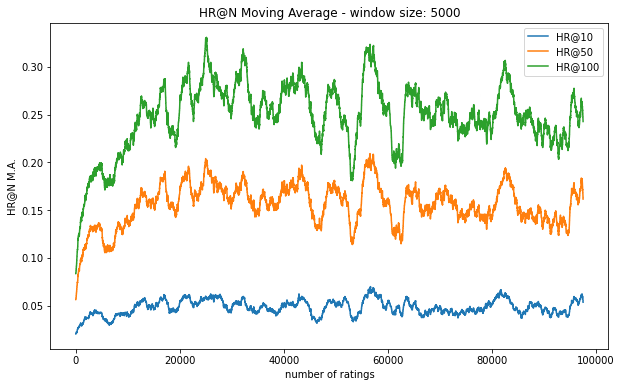

In [42]:
plt.figure(figsize=(10,6))
plt.plot(range(len(mov_avg_hr_10)), mov_avg_hr_10, label='HR@10')
plt.plot(range(len(mov_avg_hr_50)), mov_avg_hr_50, label='HR@50')
plt.plot(range(len(mov_avg_hr_100)), mov_avg_hr_100, label='HR@100')
plt.title('HR@N Moving Average - window size: 5000')
plt.xlabel('number of ratings')
plt.ylabel('HR@N M.A.')
plt.legend()
plt.savefig(fname='hr_moving_avg.png');

In [43]:
user = 'Klismam'
my_ratings = [
    (user, '200', 5), 
    (user, '176', 5),
    (user, '473', 5),
    (user, '50', 4), 
    (user, '82', 4), 
    (user, '11', 5),
    (user, '56', 5),
    (user, '69', 5),
    
]
for user, item, rating in my_ratings:
    icf.run(user, item, rating)

In [44]:
icf.user_favorites(user, n_items=15), icf.show_recommended_titles(user, n_items=15)

(['Shining, The (1980)',
  'Aliens (1986)',
  'James and the Giant Peach (1996)',
  'Seven (Se7en) (1995)',
  'Pulp Fiction (1994)',
  'Forrest Gump (1994)',
  'Star Wars (1977)',
  'Jurassic Park (1993)'],
 ['Fargo (1996)',
  'Godfather, The (1972)',
  "One Flew Over the Cuckoo's Nest (1975)",
  'Dead Man Walking (1995)',
  'English Patient, The (1996)',
  'Silence of the Lambs, The (1991)',
  'Contact (1997)',
  'Sense and Sensibility (1995)',
  'When Harry Met Sally... (1989)',
  'Shawshank Redemption, The (1994)',
  "Schindler's List (1993)",
  'Secrets & Lies (1996)',
  'Casablanca (1942)',
  'Postino, Il (1994)',
  'Toy Story (1995)'])

In [45]:
icf.get_titles()

{'255': "My Best Friend's Wedding (1997)",
 '286': 'English Patient, The (1996)',
 '298': 'Face/Off (1997)',
 '185': 'Psycho (1960)',
 '173': 'Princess Bride, The (1987)',
 '108': 'Kids in the Hall: Brain Candy (1996)',
 '772': 'Kids (1995)',
 '288': 'Scream (1996)',
 '928': 'Craft, The (1996)',
 '117': 'Rock, The (1996)',
 '200': 'Shining, The (1980)',
 '405': 'Mission: Impossible (1996)',
 '1074': 'Reality Bites (1994)',
 '176': 'Aliens (1986)',
 '357': "One Flew Over the Cuckoo's Nest (1975)",
 '210': 'Indiana Jones and the Last Crusade (1989)',
 '687': "McHale's Navy (1997)",
 '696': 'City Hall (1996)',
 '284': 'Tin Cup (1996)',
 '295': 'Breakdown (1997)',
 '473': 'James and the Giant Peach (1996)',
 '544': "Things to Do in Denver when You're Dead (1995)",
 '290': 'Fierce Creatures (1997)',
 '147': 'Long Kiss Goodnight, The (1996)',
 '121': 'Independence Day (ID4) (1996)',
 '717': 'Juror, The (1996)',
 '220': 'Mirror Has Two Faces, The (1996)',
 '1040': 'Two if by Sea (1996)',
 '51